In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import pywt
from scipy.ndimage import gaussian_filter
from numpy.fft import fft2, fftshift
import cv2

File: data/images/0.tif
Number of bands: 12
Shape: 128 x 128
CRS: None
Resolution: (1.0, 1.0)
Descriptions: (None, None, None, None, None, None, None, None, None, None, None, None)
Dtype: ('int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16')
Indexes: (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)
Normalized data shape: (12, 128, 128)


d:\CONDA\envs\N\lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


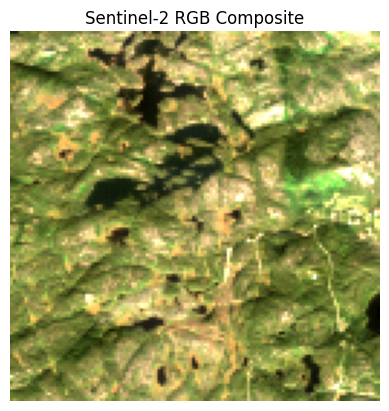

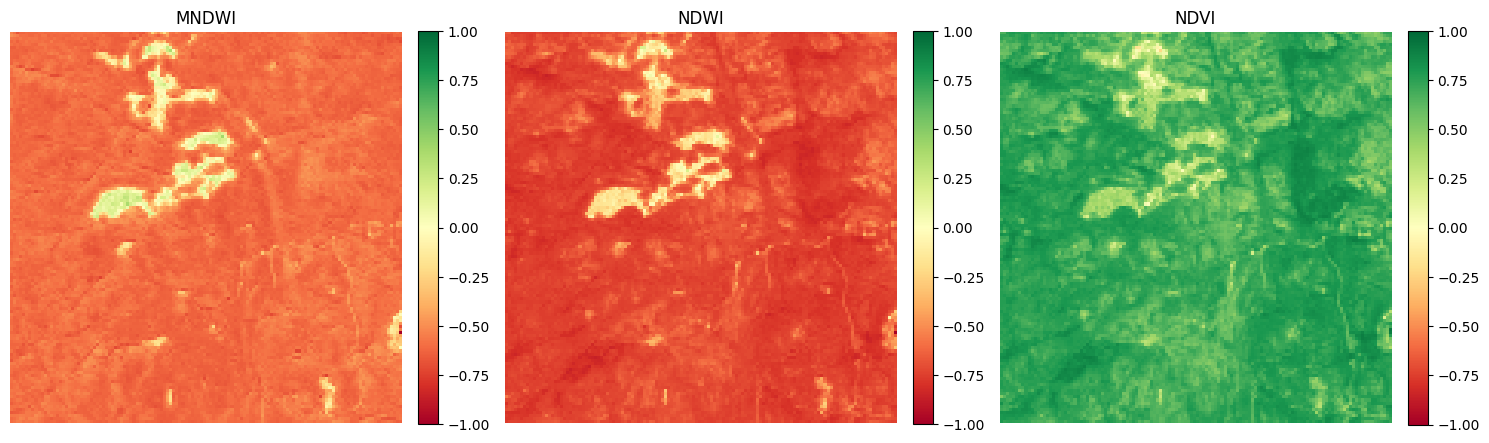

In [2]:
tif_path = "data/images/0.tif"
band_names = [
    "Coastal Aerosol (B1)",
    "Blue (B2)",
    "Green (B3)",
    "Red (B4)",
    "NIR (B8)",
    "SWIR1 (B11)",
    "SWIR2 (B12)",
    "QA Band",
    "MERIT DEM",
    "Copernicus DEM",
    "ESA World Cover Map",
    "Water Occurrence Probability",
    "MNDWI",
    "NDTI",
    "NDVI "
]
with rasterio.open(tif_path) as src:
    image = src.read()
    print(f"File: {tif_path}")
    print(f"Number of bands: {src.count}")
    print(f"Shape: {src.height} x {src.width}")
    print(f"CRS: {src.crs}")
    print("Resolution:", src.res)
    print(f"Descriptions: {src.descriptions}")
    print(f"Dtype: {src.dtypes}")
    print(f"Indexes: {src.indexes}")
normalized = np.empty_like(image, dtype=np.float32)
unnormalized = np.empty_like(image, dtype=np.float32)
for i in range(image.shape[0]):
    band = image[i]
    if i == 0:
        normalized[i] = band / 10000.0
    elif i in [1,2,3]:
        normalized[i] = band / 255.0
    elif i in [4,5,6]:
        normalized[i] = band / 1000.0
        unnormalized[i]=band/255.0
    elif i == 7:
        normalized[i] = band.astype(np.float16)
    elif i in [8, 9]:
        normalized[i] = (band - band.min()) / (band.max() - band.min() + 1e-5)
    elif i == 10:
        normalized[i] = band.astype(np.float16)
    elif i == 11:
        normalized[i] = band / 100.0

print("Normalized data shape:", normalized.shape) 

rgb = np.stack([
    normalized[3],  
    normalized[2], 
    normalized[1], 
], axis=-1)
mndwi = (normalized[2] - unnormalized[5]) / (normalized[2] + unnormalized[5] + 1e-6)
ndwi = (normalized[2] - unnormalized[4]) / (normalized[2] + unnormalized[4] + 1e-6)
ndvi = (unnormalized[4] - normalized[3]) / (unnormalized[4] + normalized[3] + 1e-6)
# mndwi = (normalized[2] - normalized[5]) / (normalized[2] + normalized[5] + 1e-6)
# ndti  = (normalized[5] - normalized[6]) / (normalized[5] + normalized[6] + 1e-6)
mndwi = np.clip(mndwi, -1, 1)
ndwi = np.clip(ndwi, -1, 1)
ndvi = np.clip(ndvi, -1, 1)
spect = np.stack([mndwi, ndwi,ndvi], axis=-1)
rgb /= np.percentile(rgb, 98)
rgb = np.clip(rgb, 0, 1)
plt.imshow(rgb)
plt.title("Sentinel-2 RGB Composite")
plt.axis("off")
plt.show()

titles = ['MNDWI', 'NDWI','NDVI']
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axs):
    im = ax.imshow(spect[..., i], cmap='RdYlGn', vmin=-1, vmax=1)
    ax.set_title(titles[i])
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [24]:
class SentinelSegmentationGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=8, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        batch_idxs = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_paths = [self.image_paths[i] for i in batch_idxs]
        batch_mask_paths = [self.mask_paths[i] for i in batch_idxs]

        X = [self._load_and_normalize(img_path) for img_path in batch_image_paths]
        y = [self._load_mask(mask_path) for mask_path in batch_mask_paths]

        return np.stack(X, axis=0), np.stack(y, axis=0)
    @staticmethod
    def highpass_filter(band, sigma=2):
        return band - gaussian_filter(band, sigma=sigma)
    @staticmethod
    def fft_log(band):
        freq = fftshift(fft2(band))
        return np.log1p(np.abs(freq))
    @staticmethod
    def wavelet_features(band):
        cA, (cH, cV, cD) = pywt.dwt2(band, 'haar')
        return cH, cV, cD
    @staticmethod
    def gradient_from_dem(dem):
        gx, gy = np.gradient(dem)
        return np.hypot(gx, gy)
    @staticmethod
    def pad_to_shape(arr, shape=(128, 128)):
            return np.pad(arr, [(0, shape[0]-arr.shape[0]), (0, shape[1]-arr.shape[1])], mode='constant')
    def _load_and_normalize(self, path):
        with rasterio.open(path) as src:
            image = src.read()  # (12, H, W)
        unnormalized = np.empty_like(image, dtype=np.float32)
        normalized = np.empty_like(image, dtype=np.float32)
        for i in range(image.shape[0]):
            band = image[i]
            if i == 0:
                normalized[i] = band / 10000.0
            elif i in [1,2,3]:
                normalized[i] = band / 255.0
            elif i in [4,5,6]:
                normalized[i] = band / 1000.0
                unnormalized[i]=band/255.0
            elif i == 7:
                normalized[i] = band.astype(np.float16)
            elif i in [8, 9]:
                normalized[i] = (band - band.min()) / (band.max() - band.min() + 1e-5)
                unnormalized[i] = band.astype(np.float16)
            elif i == 10:
                normalized[i] = band.astype(np.float16)
            elif i == 11:
                normalized[i] = band / 100.0
        
        green = normalized[2]
        swir1 = unnormalized[6]
        swir2 = unnormalized[5]
        nir=unnormalized[4]
        red=normalized[3]

        mndwi = (green - swir1) / (green + swir1 + 1e-6)
        ndwi = (green - nir) / (green + nir + 1e-6)
        ndvi = (nir - red) / (nir + red + 1e-6)
        ndwi = np.clip(ndwi, -1, 1)
        mndwi = np.clip(mndwi, -1, 1)
        ndvi = np.clip(ndvi, -1, 1)
        indices = np.stack([mndwi, ndwi,ndvi], axis=0)  # (2, H, W)


        water_mask = (normalized[11] > 0.8).astype(np.float32)
        dem_diff = normalized[8] - normalized[9]  # (MERIT - Copernicus)
        
        # NDWI Gradient (boundary focus)
        ndwi_dx = np.gradient(ndwi, axis=0)
        ndwi_dy = np.gradient(ndwi, axis=1)
        ndwi_grad = np.sqrt(ndwi_dx**2 + ndwi_dy**2)
        # --- DSP Features ---
        hp_nir = self.highpass_filter(nir)                # 1
        # fft_nir = self.fft_log(nir)    
        # fft_nir = cv2.resize(fft_nir, (128, 128), interpolation=cv2.INTER_LINEAR)                   # 1
        cH, cV, cD = self.wavelet_features(nir)           # 3
        dem_grad = self.gradient_from_dem(unnormalized[8]) # 1
        dem_grad2 = self.gradient_from_dem(normalized[9]) # 1
        
        wavelet_stack = np.stack([
            cv2.resize(cH, (128, 128), interpolation=cv2.INTER_LINEAR),
            cv2.resize(cV, (128, 128), interpolation=cv2.INTER_LINEAR),
            cv2.resize(cD, (128, 128), interpolation=cv2.INTER_LINEAR)
        ], axis=0)

        # Stack all features
        #0-11 12,13,14 15,16,17,18 19,20
        extra_features = np.stack([dem_diff, water_mask], axis=0)
        dsp_features = np.stack([hp_nir,dem_grad,dem_grad2,ndwi_grad], axis=0)
        full_stack = np.concatenate([normalized, indices, dsp_features,wavelet_stack ,extra_features], axis=0)  # (25, H, W)
        return np.transpose(full_stack, (1, 2, 0))  # (H, W, 25)

    def _load_mask(self, path):
        mask = Image.open(path).convert("L")
        mask = np.array(mask).astype(np.float32)
        mask = (mask > 0).astype(np.float32)
        #print("Mask stats:", np.min(mask), np.max(mask), np.isnan(mask).any())

        return np.expand_dims(mask, axis=-1)

In [25]:
image_dir = "data/images"
mask_dir = "data/labels"
image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
mask_filenames = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])
image_paths = []
mask_paths = []
mask_map = {os.path.splitext(f)[0]: f for f in mask_filenames}
for img_name in image_filenames:
    base = os.path.splitext(img_name)[0]
    if base in mask_map:
        image_paths.append(os.path.join(image_dir, img_name))
        mask_paths.append(os.path.join(mask_dir, mask_map[base]))
    else:
        print(f"⚠️ No matching label for image: {img_name}")
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    image_paths, mask_paths, test_size=0.30, random_state=42
)
val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs, temp_masks, test_size=0.5, random_state=42
)
train_gen = SentinelSegmentationGenerator(train_imgs, train_masks, batch_size=8)
train_gen2 = SentinelSegmentationGenerator(train_imgs, train_masks, batch_size=8, shuffle=False)
val_gen   = SentinelSegmentationGenerator(val_imgs, val_masks, batch_size=8, shuffle=False)
test_gen  = SentinelSegmentationGenerator(test_imgs, test_masks, batch_size=8, shuffle=False)

In [26]:
X_batch, y_batch = train_gen2[3]
print("Input shape:", X_batch.shape)  # Expect (8, H, W, 25)
print("Mask shape:", y_batch.shape)   # Expect (8, H, W, 1) or (8, H, W)


Input shape: (8, 128, 128, 24)
Mask shape: (8, 128, 128, 1)


d:\CONDA\envs\N\lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


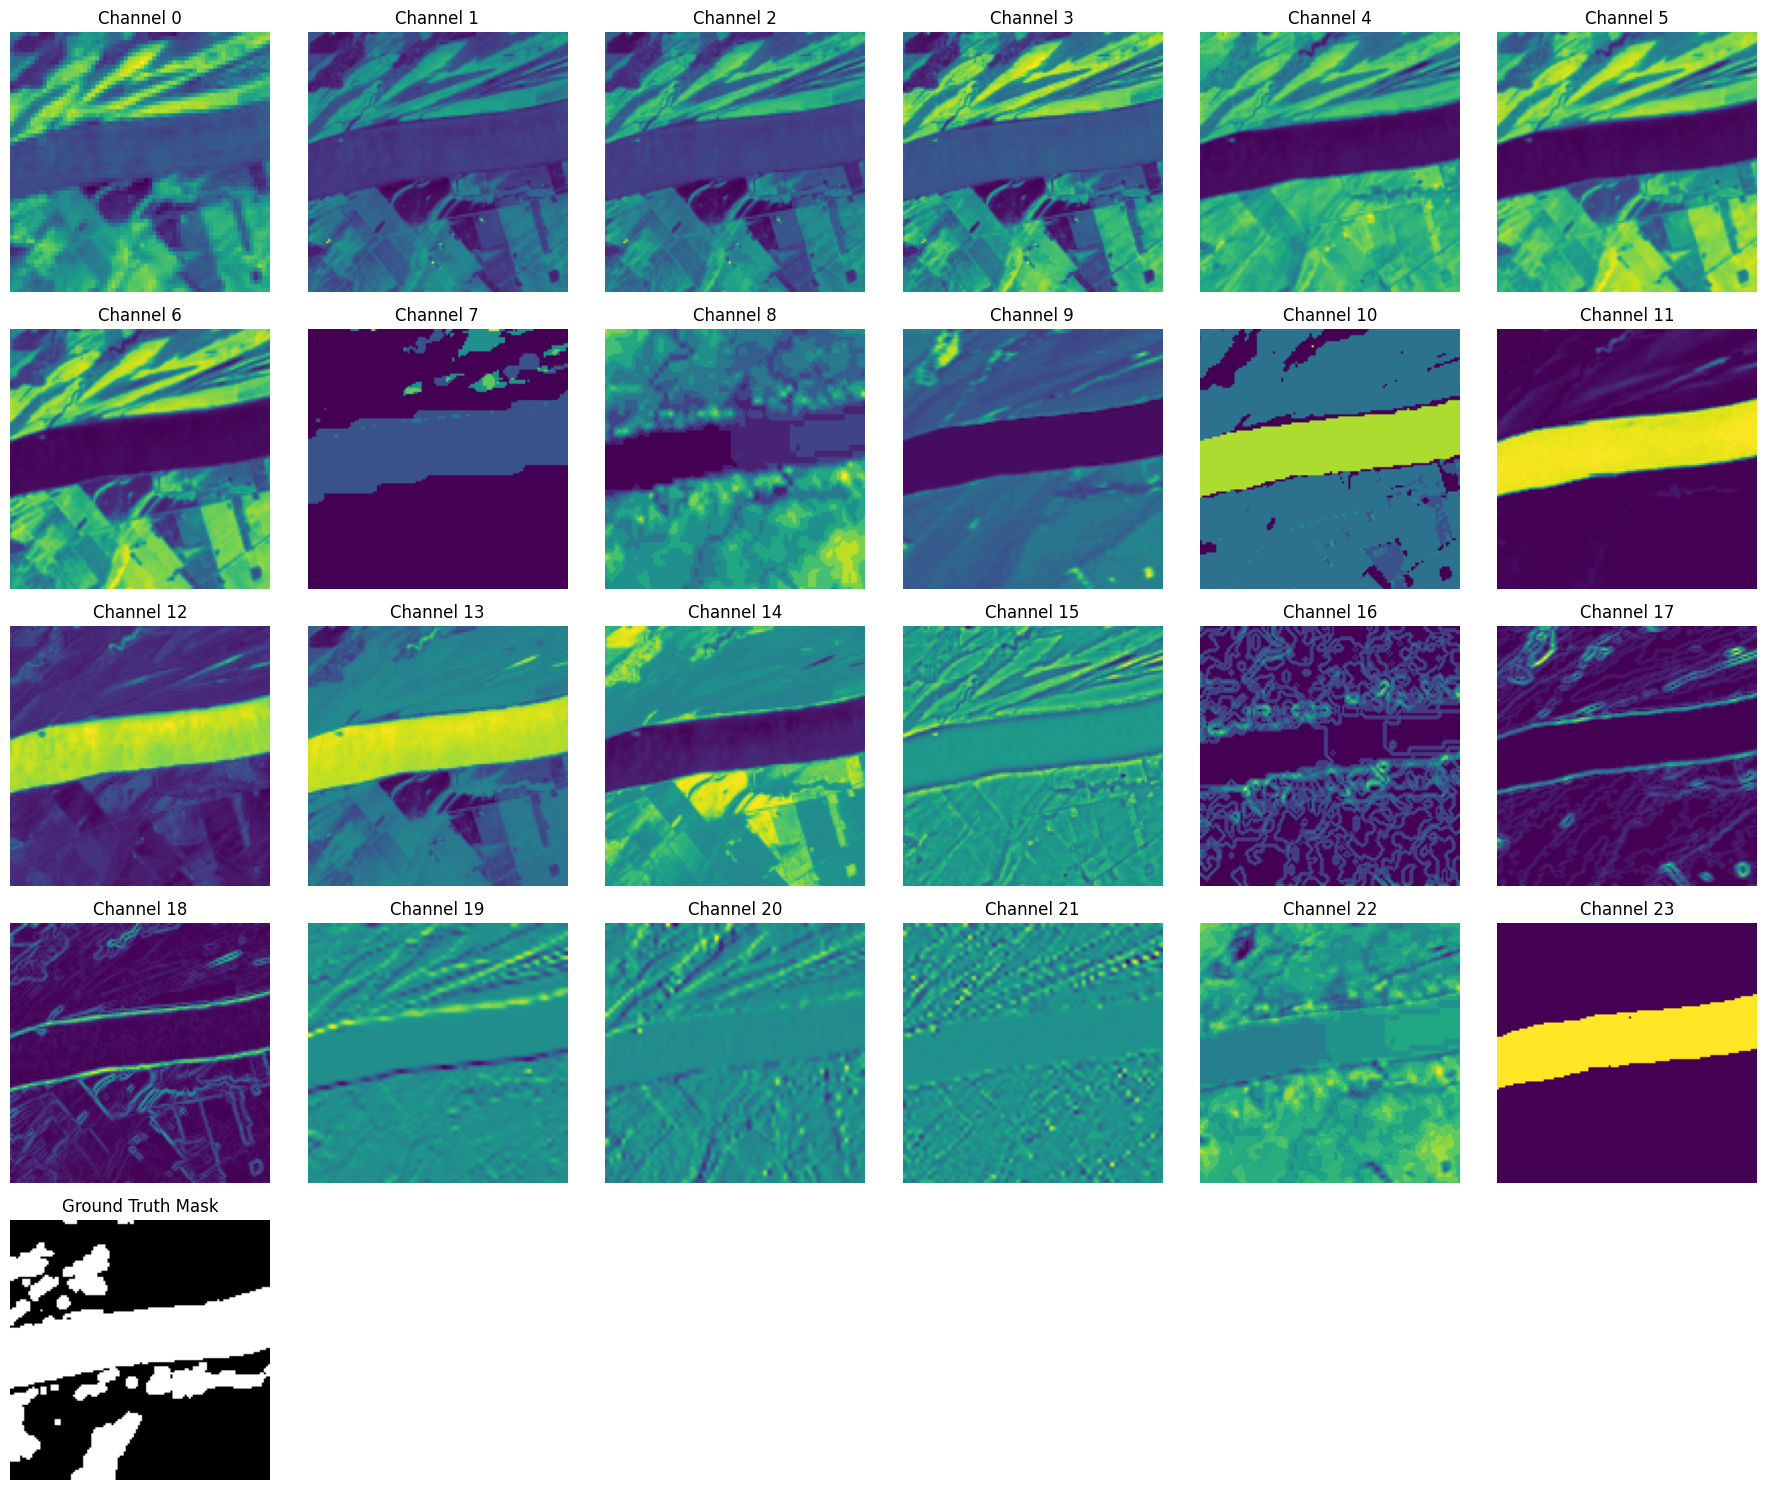

In [27]:
idx = 0  # Index within batch
num_channels = X_batch.shape[-1]
cols = 6
rows = (num_channels + 1 + cols - 1) // cols  # +1 for the label mask

plt.figure(figsize=(3 * cols, 3 * rows))

# Plot each channel
for i in range(num_channels):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(X_batch[idx, :, :, i], cmap='viridis')
    plt.title(f"Channel {i}")
    plt.axis("off")

# Plot the label/mask
plt.subplot(rows, cols, num_channels + 1)
plt.imshow(y_batch[idx].squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.tight_layout()
plt.show()


In [44]:
# def unet_model(input_size=(128, 128, 12)):
#     inputs = layers.Input(input_size)
#     l2_reg = regularizers.l1_l2(0.1,0.01)
#     c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
#     #c1=layers.BatchNormalization()(c1)
#     # c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
#     p1 = layers.MaxPooling2D((2, 2))(c1)

#     c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
#     #c2=layers.BatchNormalization()(c2)
#     # c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
#     p2 = layers.MaxPooling2D((2, 2))(c2)

#     c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
#     #c3=layers.BatchNormalization()(c3)
#     # c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
#     p3 = layers.MaxPooling2D((2, 2))(c3)

#     c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
#     #c4=layers.BatchNormalization()(c4)
#     # c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
#     p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

#     # Bottleneck
#     c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
#     #c5=layers.BatchNormalization()(c5)
#     # c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

#     # Decoder
#     u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
#     u6 = layers.concatenate([u6, c4])
#     c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
#     #c6=layers.BatchNormalization()(c6)
#     # c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

#     u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
#     u7 = layers.concatenate([u7, c3])
#     c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
#     #c7=layers.BatchNormalization()(c7)
#     # c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

#     u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
#     u8 = layers.concatenate([u8, c2])
#     c8 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
#     #c8=layers.BatchNormalization()(c8)
#     # c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

#     u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
#     u9 = layers.concatenate([u9, c1])
#     c9 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
#     #c9=layers.BatchNormalization()(c9)
#     # c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)


#     output_activation = 'sigmoid'


#     outputs = layers.Conv2D(1, (1, 1), activation=output_activation)(c9)

#     model = models.Model(inputs=[inputs], outputs=[outputs])
#     return model


In [15]:
def unet_model(input_size=(128, 128, 5)):
    inputs = layers.Input(input_size)
    l2_reg = regularizers.l1_l2(0.1,0.01)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    #c1=layers.BatchNormalization()(c1)
    #c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    #c2=layers.BatchNormalization()(c2)
    #c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    #c3=layers.BatchNormalization()(c3)
    #c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    # #c4=layers.BatchNormalization()(c4)
    # #c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    # p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c5 = layers.Dropout(0.3)(c5)
    #c5=layers.BatchNormalization()(c5)
    #c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # # Decoder
    # u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    # u6 = layers.concatenate([u6, c4])
    # c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    # #c6=layers.BatchNormalization()(c6)
    # #c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    #c7=layers.BatchNormalization()(c7)
    #c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    #c8=layers.BatchNormalization()(c8)
    #c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    #c9=layers.BatchNormalization()(c9)
    #c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)


    output_activation = 'sigmoid'


    outputs = layers.Conv2D(1, (1, 1), activation=output_activation)(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model


In [16]:
model = unet_model()
model.compile(
    optimizer=Adam(learning_rate=1e-4
    ,
      clipnorm=1.0,
    #   clipvalue=0.5
      ),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss', mode='min', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)]

In [17]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 5  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 64  2944        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 64, 64, 64)  0           ['conv2d_16[0][0]']              
                                                                                            

In [18]:
hist = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 0.4512 - accuracy: 0.7853 - recall_2: 0.3400 - precision_2: 0.7331
Epoch 1: val_loss improved from inf to 0.33099, saving model to best_model.h5
27/27 [==============================] - 27s 363ms/step - loss: 0.4512 - accuracy: 0.7853 - recall_2: 0.3400 - precision_2: 0.7331 - val_loss: 0.3310 - val_accuracy: 0.8864 - val_recall_2: 0.5819 - val_precision_2: 0.9670 - lr: 1.0000e-04
Epoch 2/100
27/27 [==============================] - ETA: 0s - loss: 0.3278 - accuracy: 0.8892 - recall_2: 0.6670 - precision_2: 0.9033
Epoch 2: val_loss improved from 0.33099 to 0.28373, saving model to best_model.h5
27/27 [==============================] - 2s 64ms/step - loss: 0.3278 - accuracy: 0.8892 - recall_2: 0.6670 - precision_2: 0.9033 - val_loss: 0.2837 - val_accuracy: 0.8991 - val_recall_2: 0.6663 - val_precision_2: 0.9234 - lr: 1.0000e-04
Epoch 3/100
26/27 [===========================>..] - ETA: 0s - loss: 0.3191 - accuracy: 0.89

In [19]:
model = load_model("best_model.h5")

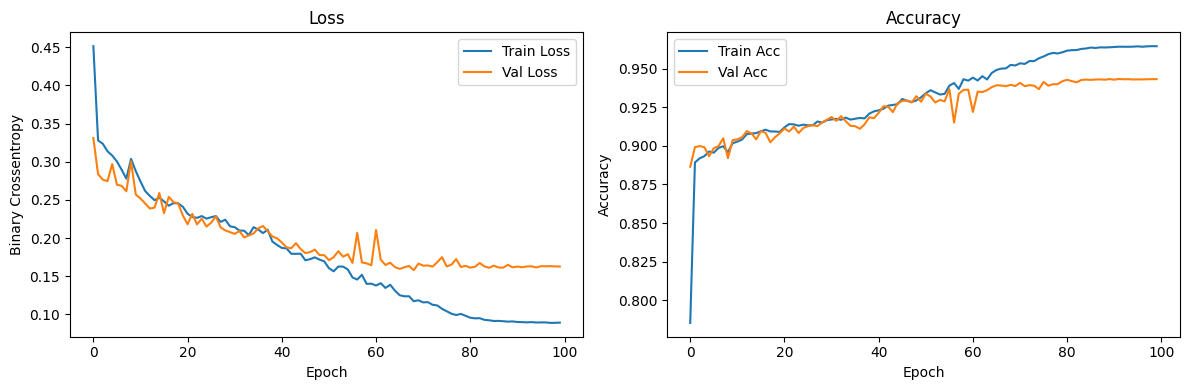

In [20]:
def plot_history(hist):
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Crossentropy')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_history(hist)

In [ ]:
model.evaluate(test_gen)
#1-6 only --> 0.9418 acc
#

6/6 [==============================] - 1s 35ms/step - loss: 0.1698 - accuracy: 0.9418 - recall_2: 0.8269 - precision_2: 0.8674


[0.16984933614730835,
 0.9417658448219299,
 0.8268678188323975,
 0.8674440979957581]

1/1 [==============================] - 1s 619ms/step


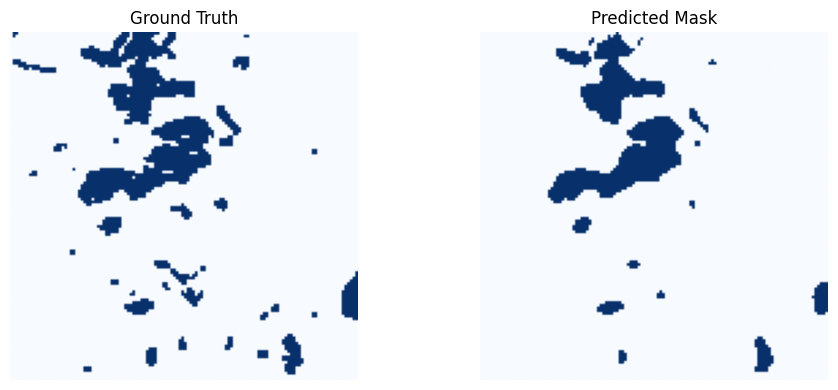

In [22]:
img = train_gen._load_and_normalize("data/images/0.tif")
X = np.expand_dims(img, axis=0)
pred = model.predict(X)[0]
binary_pred = (pred > 0.5).astype(np.uint8)
actual_mask = train_gen._load_mask("data/labels/0.png").squeeze()
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(actual_mask, cmap='Blues')
plt.title("Ground Truth")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(binary_pred, cmap='Blues')
plt.title("Predicted Mask")
plt.axis("off")
plt.tight_layout()
plt.show()
